In [460]:
from __future__ import print_function, division
import numpy as np
import scipy as sp
import neurofit as nf
import pyspike as pyspk
from scipy.signal import resample

import sys
import os
sys.path.append("../") # for importing utils and glm

import utils
from neurofit import utils as nfutils

from corner import corner

# plotting packages
%matplotlib inline
from matplotlib.pyplot import * # plotting functions
import seaborn as sns           # data visualization package
sns.set_style("whitegrid")

write = True

In [461]:
from models import cosstrf, GLM_cos

In [462]:
# load mcmc results
cell = "blublu0809_1_B"
stim_type = "conspecific"

# load mcmc results
folder = "crcns_glm_cm"
root = "/scratch/dstrf/results/"
path = "/".join([root,folder,cell,""])

results = {}
for f in next(os.walk(path))[2]:
    name, ext = f.split(".")
    if ext == "npz":
        results[name] = np.load(path+f)
        
#results = [f for f in next(walk(path))[2] if f.split(".")[1] == "npz"]
R = results[results.keys()[0]]
maxlik = R['map']
chain = R['chain']

In [463]:
# glm model settings
ncos = 10
spcos = 5
dt = 0.001
tcoslin = 1
hcoslin = 10
channels = 1

# data parameters 
nspec = 30
t_dsample = 5
tlen = int(np.rint(150/t_dsample))
plen = int(np.rint(50/t_dsample))
psth_smooth = 5/t_dsample
compress = 1

num_assim_stims = 15

# setup cosine basis
tbas, fromt, tot = utils.cosbasis(tlen,ncos,tcoslin,retfn=True,norm=True)
hbas, fromh, toh = utils.cosbasis(plen,spcos,hcoslin,retfn=True)

# load data from crcns
stims,durations,spikes_data,spiky_data,names = utils.load_crcns(cell,stim_type,nspec,t_dsample,compress,names=True)
psth_data = [utils.psth_spiky(spk,1,smooth=psth_smooth,dsample=t_dsample) for spk,st in zip(spiky_data,stims)]

# separate the simulation and validation sets
assim_psth, test_psth = np.split(psth_data,[num_assim_stims])
assim_spikes, test_spikes = np.split(spikes_data,[num_assim_stims])
assim_spiky, test_spiky = np.split(spiky_data,[num_assim_stims])
assim_stims, test_stims = stims[:num_assim_stims], stims[num_assim_stims:]
assim_dur, test_dur = np.split(durations,[num_assim_stims])

# calculate correlation between even and odd trial psths
eocorr = [utils.evenoddcorr(spks,dur,dsample=t_dsample,smooth=psth_smooth) for spks,dur in zip(spikes_data,durations)]
print("EO: {:.2f}".format(np.mean(eocorr)))

EO: 0.52


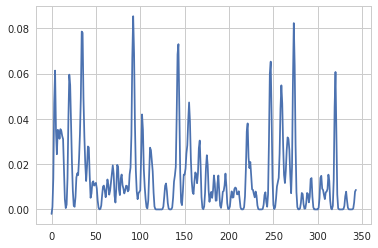

In [464]:
plot(psth_data[0])

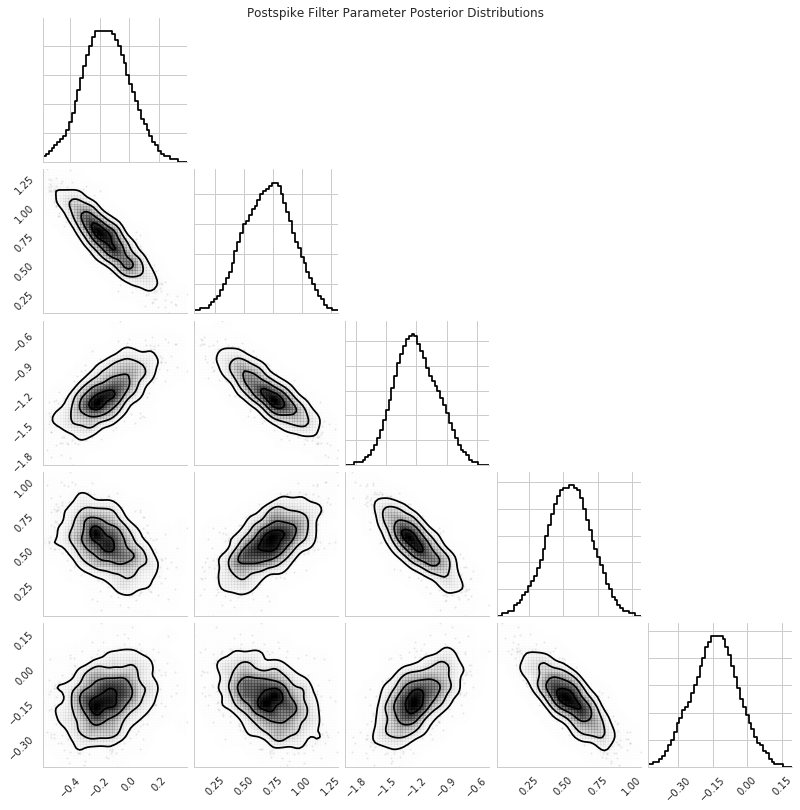

In [465]:
corner(chain[:,-spcos:],bins=50,
       #truths=maxlik[:4],
       smooth=2,smooth1d=2);
sns.despine(right=True)
suptitle("Postspike Filter Parameter Posterior Distributions")
#savefig("cm_neuron-corner.svg")

In [466]:
reload(utils)

<module 'utils' from '../utils.pyc'>

In [467]:
model = GLM_cos(channels,nspec,tlen,plen,ncos,spcos,tcoslin,hcoslin,nonlin=np.exp,spike=True,dt=dt)
model.set(maxlik)

map_corr, mappsth = utils.glm_sample_validate(model,maxlik,test_stims,test_psth,ntrials=10,dsample=False,smooth=psth_smooth)
ppcorr, pppsths = utils.posterior_predict_corr(model,test_stims,test_psth,chain,False,psth_smooth,ntrials=100)
corr_means = np.mean([map_corr,ppcorr,eocorr[num_assim_stims:]],axis=1)
print("\nMAP: {:.2f}, Dist: {:.2f}, EO: {:.2f}".format(corr_means[0],corr_means[1],corr_means[2]))
print("MAP/EO: {:.2f}, Dist/EO: {:.2f}".format(corr_means[0]/corr_means[2],corr_means[1]/corr_means[2]))

if write:
    f = open("/".join((root,folder,""))+"results.csv","a+")
    f.write("{},{:.3f},{:.3f}\n".format(cell,corr_means[0],corr_means[1]))
    f.close()


MAP: 0.48, Dist: 0.54, EO: 0.57
MAP/EO: 0.84, Dist/EO: 0.94


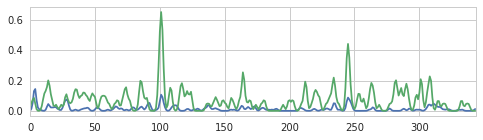

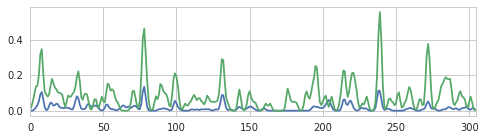

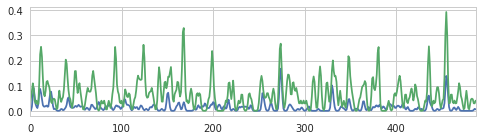

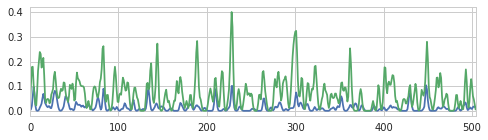

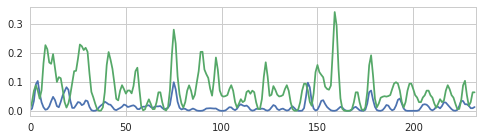

In [468]:
for t, m in zip(test_psth,mappsth):
    figure(figsize=(8,2))
    xlim(0,len(t))
    plot(t)
    plot(m)

In [469]:
from neurofit import graphics
import scipy as sp

lower,upper = sp.stats.norm.interval(0.68,np.mean(chain,0),np.std(chain,0))
idx = []
for i,(l,u) in enumerate(zip(lower,upper)):
    if l < 0 < u: #and i < nspec:
        idx.append(i)

clip_chain = chain.copy()
clip_chain[:,idx] *= 0

mu = np.mean(clip_chain,axis=0)
med = np.median(clip_chain,axis=0)

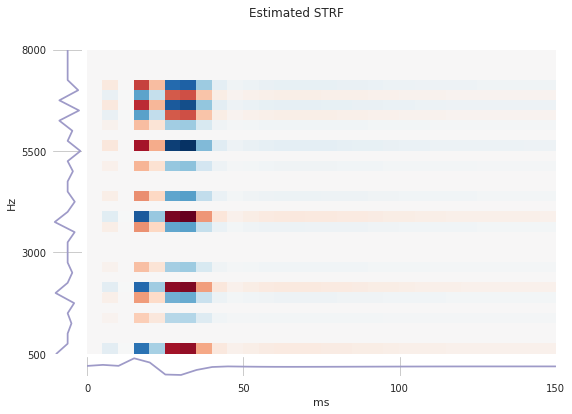

In [470]:
par = cosstrf(channels,nspec,tlen,ncos,tcoslin)
par.set(mu[1:-spcos])

figure(figsize=(9,6))
graphics.strf_plot(par.sfilt,np.hstack(([[0]],par.tfilt))[:,:-1],500,8000,5)
suptitle("Estimated STRF")

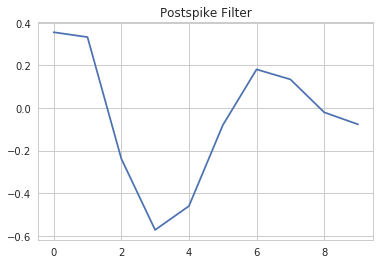

In [471]:
title("Postspike Filter")
plot(fromh(mu[-spcos:]))

In [472]:
figroot = "/scratch/dstrf/figures/crcns_exemplars/" + cell + "/"


rcParams["svg.fonttype"]='none'
rc('font',**{'family':'serif','serif':['Times']})
rc('font',**{'family':'sans-serif','sans-serif':['Arial']})

ch = sns.color_palette("cubehelix",8).as_hex()
ch4 = sns.color_palette("cubehelix",4).as_hex()

rcParams["svg.fonttype"]='none'
rc('font',**{'family':'serif','serif':['Times']})
rc('font',**{'family':'sans-serif','sans-serif':['Arial']})

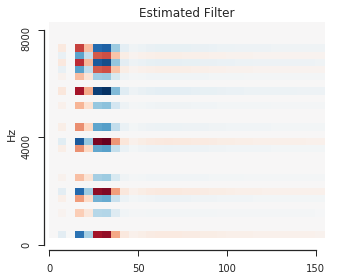

In [473]:
sns.set_style("ticks")

figure(figsize=(5,4))
model.set(np.mean(chain,0))

from neurofit import graphics

par.filt = np.hstack((np.zeros((nspec,1)),par.filt))

#figure()
title("Estimated Filter")
#graphics.strf_plot(M.k.sfilt,M.k.tfilt,0,8000,t_dsample)
sns.heatmap(np.flipud(par.filt),cbar=False)

yticks(range(-1,30,15),range(0,8100,int(8000/2)),rotation=45);
xticks([0,10,20,30],[0,50,100,150])
ylabel("Hz")


sns.despine(trim=True, offset=5)
tight_layout()

yticks(range(-1,30,15),range(0,8100,int(8000/2)),rotation=90);

savefig(figroot+"glm_strf.svg",bbox_inches='tight')

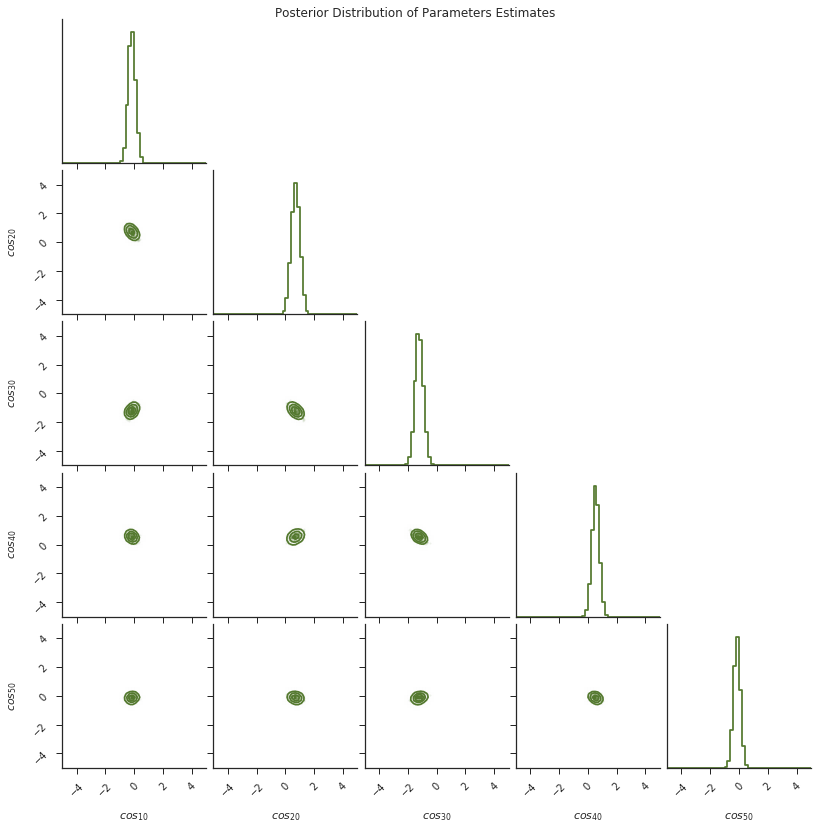

In [474]:
from corner import corner

figure(figsize=(8,8))
sns.set_style("ticks")

matlabs = [r'$cos_{10}$',r'$cos_{20}$',r'$cos_{30}$',r'$cos_{40}$',r'$cos_{50}$']
c = corner(chain[:,-spcos:],
        range=[[-5,5],
               [-5,5],
               [-5,5],
               [-5,5],
               [-5,5]],
       bins=50, smooth=1,smooth1d=1,
       labels=matlabs,
       #plot_contours=False,
       color=ch4[1],truth_color=ch4[0],max_n_ticks=5)

for i, a in enumerate(c.axes):
    
    if i%6 == 0:
        a.grid(0)
        #sns.despine(left=True)
        a.get_yaxis().set_visible(False)
    else:
        #a.grid()
        sns.despine()
suptitle("Posterior Distribution of Parameters Estimates")

savefig(figroot+"glm_corner.svg",bbox_inches='tight')

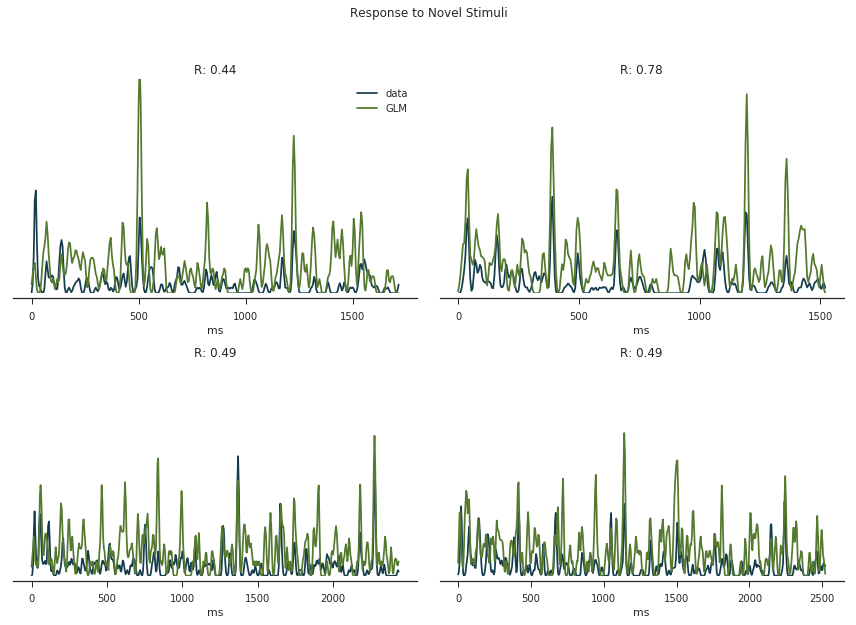

In [475]:
i = 0

figure(figsize=(12,8))

for i in range(4):
    subplot(2,2,i+1)
    dur = len(test_psth[i])*t_dsample
    plot(test_psth[i],ch4[0],label="data")
    plot(mappsth[i]/2,ch4[1],label="GLM")
    if i == 0: legend()
    yticks([])
    xlabel("ms")
    ylim(0,0.3)
    xticks(np.arange(0,dur/t_dsample,100),np.arange(0,dur,100*t_dsample))
    title("R: {:.2f}".format(np.corrcoef(test_psth[i],mappsth[i])[0][1]))
    
suptitle("Response to Novel Stimuli",y=1.08)
tight_layout()
sns.despine(trim=False, left=True, offset=5)
tight_layout()

savefig(figroot+"glm_psth.svg",bbox_inches='tight')

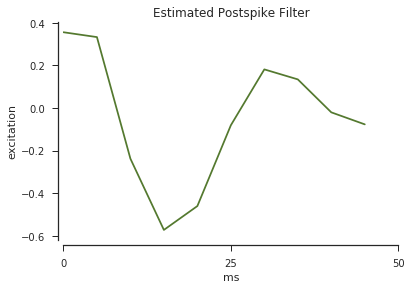

In [476]:
title("Estimated Postspike Filter")
plot(fromh(mu[-spcos:]),ch4[1])
yticks
sns.despine(trim=False, offset=5)
xticks(range(0,11,5),range(0,51,25))
xlim(0)
xlabel("ms")
ylabel("excitation")
savefig(figroot+"glm_post.svg",bbox_inches='tight')